In [79]:
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
from scipy.stats import randint, uniform
import statsmodels.api as sm
from rich.console import Console
from rich.table import Table
from rich.live import Live
from rich import box

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer

import xgboost as xgb
from catboost import CatBoostRegressor

## **Câu 1. Giá thuê phòng trọ thay đổi như thế nào giữa các quận khác nhau ở TP.HCM?**

**Câu hỏi:** Giá thuê phòng trọ tại TP.HCM phân bố như thế nào giữa các quận? Liệu có sự phân tầng rõ ràng về mặt bằng giá theo vị trí địa lý, và mức độ chênh lệch giữa khu vực trung tâm và ngoại thành là bao nhiêu?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu lựa chọn khu vực (Cho người thuê):** Xác định quận nào phù hợp với ngân sách, cân đối giữa chi phí sinh hoạt và khoảng cách đến nơi làm việc/học tập.
* **Chiến lược định giá theo địa lý (Cho chủ nhà/Môi giới):** Hiểu rõ vị thế cạnh tranh của địa điểm cho thuê, tránh định giá sai lệch so với thị trường khu vực.
* **Đánh giá tiềm năng đầu tư:** So sánh tỷ suất sinh lời giữa các quận, nhận diện khu vực có độ ổn định giá cao hoặc tiềm năng tăng trưởng.

### **A. Preprocessing**

1. **Tách tên quận từ địa chỉ:**
   * Sử dụng hàm `apply()` với `lambda` để trích xuất tên quận từ cột `address` (phần trước dấu " - ").

2. **Lọc Top 10 quận có nhiều tin đăng nhất:**
   * Sử dụng `value_counts().nlargest(10)` để đảm bảo tính đại diện thống kê, loại bỏ các quận có số lượng mẫu quá nhỏ.

3. **Loại bỏ outliers cực đoan:**
   * Lọc dữ liệu với điều kiện `price <= 30` triệu để loại bỏ các trường hợp có thể là lỗi dữ liệu hoặc bất động sản đặc biệt (villa, penthouse).

4. **Tính thống kê giá thuê theo quận:**
   * Sử dụng `groupby()` và `agg()` để tính: số lượng tin (`count`), giá trung bình (`mean`), giá trung vị (`median`), giá thấp nhất (`min`), giá cao nhất (`max`).
   * Sắp xếp theo `median` giảm dần để xếp hạng các quận từ đắt đến rẻ.

In [80]:
df = pd.read_csv("../Data/cleaned.csv")
df = df.drop(columns=['title', 'description', 'url'])

# Tách tên quận từ cột address
df['district'] = df['address'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) else x)

# Lọc top 10 quận có nhiều tin đăng nhất
top_districts = df['district'].value_counts().nlargest(10).index
df_filtered = df[df['district'].isin(top_districts)].copy()

# Loại bỏ outliers cực đoan (giá > 30 triệu, có thể là lỗi dữ liệu)
df_clean = df_filtered[df_filtered['price'] <= 30].copy()

# Tính thống kê giá thuê theo quận
price_stats = df_clean.groupby('district')['price'].agg([
    ('count', 'count'),
    ('mean', 'mean'),
    ('median', 'median'),
    ('min', 'min'),
    ('max', 'max')
]).sort_values('median', ascending=False).round(2)

print("Thống kê giá thuê theo quận (Triệu đồng):")
print(price_stats)

Thống kê giá thuê theo quận (Triệu đồng):
                 count  mean  median   min   max
district                                        
Quận Bình Thạnh   3098  4.68     4.8  0.75  27.0
Quận 10           1057  4.09     4.5  0.60  12.0
Quận Phú Nhuận     871  4.45     4.5  0.70  13.5
Quận 7            1304  4.11     4.0  0.65  13.0
Quận Tân Bình     2828  4.00     4.0  0.35  29.0
Quận Gò Vấp       2223  3.56     3.6  0.50  28.0
Quận Tân Phú      1688  3.60     3.6  0.50  23.0
Quận 9            1009  3.19     3.3  0.10  20.0
Quận 12           1065  2.99     3.0  0.60  10.5
Quận Bình Tân     1053  3.00     3.0  0.75  10.0


### **B. Analysis**

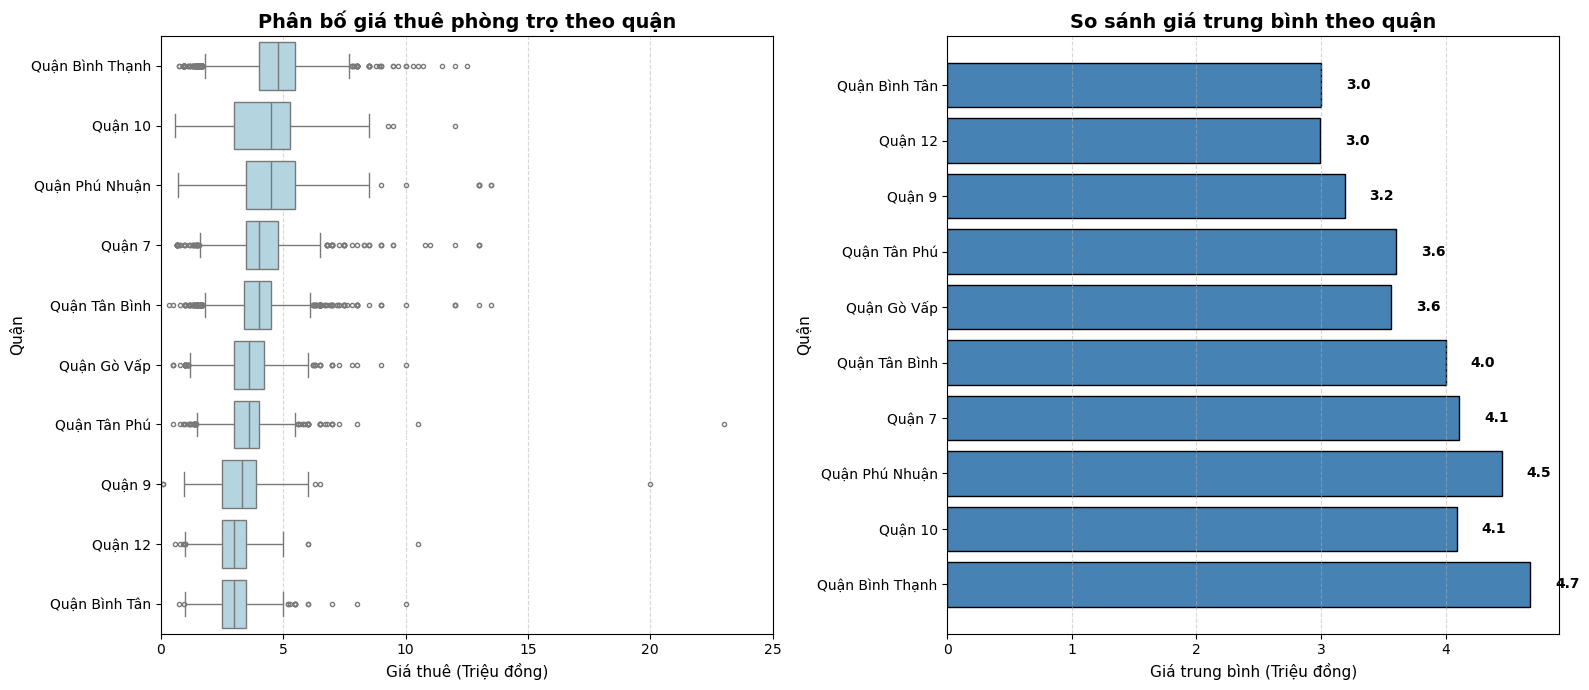

Quận có giá cao nhất: Quận Bình Thạnh (4.80 triệu)
Quận có giá thấp nhất: Quận Bình Tân (3.00 triệu)


In [81]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 1. Boxplot - Phân bố giá
sns.boxplot(data=df_clean, x='price', y='district', 
            order=price_stats.index, color='lightblue', 
            showfliers=True, fliersize=3, ax=axes[0])
axes[0].set_title('Phân bố giá thuê phòng trọ theo quận', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Giá thuê (Triệu đồng)', fontsize=11)
axes[0].set_ylabel('Quận', fontsize=11)
axes[0].set_xlim(0, 25)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# 2. Biểu đồ cột - So sánh giá trung bình
bars = axes[1].barh(price_stats.index, price_stats['mean'], color='steelblue', edgecolor='black')
axes[1].set_title('So sánh giá trung bình theo quận', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Giá trung bình (Triệu đồng)', fontsize=11)
axes[1].set_ylabel('Quận', fontsize=11)
axes[1].grid(axis='x', linestyle='--', alpha=0.5)

for i, (idx, val) in enumerate(price_stats['mean'].items()):
    axes[1].text(val + 0.2, i, f'{val:.1f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Quận có giá cao nhất: {price_stats.index[0]} ({price_stats.iloc[0]['median']:.2f} triệu)")
print(f"Quận có giá thấp nhất: {price_stats.index[-1]} ({price_stats.iloc[-1]['median']:.2f} triệu)")

#### **1. Nhận định về phân tầng giá theo khu vực**

Dựa trên dữ liệu thu thập được từ 10 quận, ta thấy có sự phân hóa rõ rệt về mức giá thuê phòng trọ, phản ánh vị trí địa lý và mức độ phát triển của từng khu vực. Cụ thể:

**Nhóm giá cao (Trung vị từ 4.5 - 4.8 triệu/tháng):**
- Dẫn đầu là Quận Bình Thạnh với mức giá trung vị cao nhất (4.8 triệu) và cũng là quận có số lượng tin đăng nhiều nhất (3098 tin), cho thấy đây là "điểm nóng" về nhu cầu nhà ở.
- Tiếp theo là Quận Phú Nhuận và Quận 10 cùng mức trung vị 4.5 triệu. Đây là các quận trung tâm hoặc sát trung tâm, thuận tiện giao thông nên mặt bằng giá được thiết lập ở mức cao.

**Nhóm giá trung bình (Trung vị từ 3.6 - 4.0 triệu/tháng):**
- Bao gồm Quận 7 và Quận Tân Bình (4.0 triệu), theo sau là Quận Gò Vấp và Quận Tân Phú (3.6 triệu).
- Đây là phân khúc sôi động với lượng dữ liệu lớn (đặc biệt là Tân Bình và Gò Vấp), phù hợp với đại đa số người đi làm và sinh viên có thu nhập khá.

**Nhóm giá rẻ (Trung vị từ 3.0 - 3.3 triệu/tháng):**
- Gồm Quận 9 (3.3 triệu), Quận 12 và Quận Bình Tân (3.0 triệu).
- Đây là các quận vùng ven, xa trung tâm hơn, phù hợp cho đối tượng ưu tiên tiết kiệm chi phí. Chênh lệch giá trung vị giữa quận cao nhất (Bình Thạnh) và thấp nhất (Bình Tân) lên tới 1.8 triệu đồng/tháng.

#### **2. Sự biến động giá (Độ phân tán dữ liệu)**

Biểu đồ Boxplot cho thấy sự đa dạng về loại hình phòng trọ trong cùng một quận:

**Biên độ dao động lớn nhất:**
- Quận Tân Bình và Quận Gò Vấp tuy có giá trung bình thuộc nhóm giữa, nhưng lại ghi nhận các giá trị ngoại lai (outliers) cực lớn (Max lần lượt là 29 triệu và 28 triệu). Điều này cho thấy tại đây tồn tại song song cả phân khúc phòng trọ bình dân và các căn hộ dịch vụ cao cấp.

**Biên độ dao động ổn định:**
- Các quận như Quận 12 hay Bình Tân có hộp (box) ngắn hơn và ít điểm ngoại lai đột biến hơn, cho thấy giá thuê tại đây khá đồng đều và tập trung chủ yếu ở phân khúc bình dân.

**Trường hợp Quận 9:**
- Mặc dù giá trung vị thấp (3.3 triệu) nhưng khoảng giá trải rất rộng (từ 0.1 triệu đến 20 triệu), phản ánh sự pha trộn giữa các khu trọ sinh viên giá rẻ (Làng đại học) và các khu căn hộ cao cấp mới nổi.

#### **3. Kết luận**

Giá thuê phòng trọ tại TP.HCM không đồng nhất mà giảm dần từ các quận trung tâm/sát trung tâm ra phía ngoại thành. Quận Bình Thạnh là khu vực đắt đỏ và sầm uất nhất, trong khi Quận Bình Tân và Quận 12 là lựa chọn tối ưu về chi phí. Đáng chú ý, các quận như Tân Bình hay Gò Vấp cung cấp sự lựa chọn đa dạng nhất, đáp ứng được cả nhu cầu bình dân lẫn cao cấp.

## **Câu 2. Tiện nghi nào là ranh giới để phân biệt 2 loại phòng bình dân và cao cấp?**

**Câu hỏi:** Trong số các tiện nghi phòng trọ, tiện nghi nào tạo ra sự khác biệt rõ rệt nhất giữa phân khúc bình dân và cao cấp? Liệu có tồn tại một "ngưỡng tiện nghi" để phân định hai tầng lớp này?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu đầu tư nâng cấp (Cho chủ nhà):** Xác định tiện nghi nào mang lại ROI cao nhất khi cải tạo phòng trọ, thay vì đầu tư dàn trải vào nhiều hạng mục.
* **Lựa chọn thông minh (Cho người thuê):** Hiểu rõ mình đang trả tiền cho tiện nghi nào, tránh thuê phòng "overpriced" do các tiện ích không cần thiết.
* **Định vị sản phẩm (Cho môi giới/developer):** Thiết kế gói tiện nghi chuẩn cho từng phân khúc khách hàng mục tiêu.

### **A. Preprocessing**

1. **Xác định biến tiện nghi:**
   * Loại trừ các cột phi tiện nghi: `title`, `price`, `area`, `address`, `description`, `url`, `district`, `ward`, `phone`, `author_name`, `time`.
   * Chỉ giữ lại các cột có kiểu dữ liệu số học hoặc boolean đại diện cho tiện nghi (điều hòa, nóng lạnh, wifi, gác lửng, v.v.).

2. **Phân loại phòng theo giá:**
   * Tính Q25 (phân vị 25%) và Q75 (phân vị 75%) của giá thuê.
   * Sử dụng `pd.cut()` để chia thành 3 nhóm:
     - **Bình dân:** Giá ≤ Q25
     - **Trung cấp:** Q25 < Giá ≤ Q75
     - **Cao cấp:** Giá > Q75

3. **Tính tỷ lệ có tiện nghi:**
   * Với mỗi tiện nghi, sử dụng `groupby()` và `mean()` để tính % phòng có tiện nghi đó trong từng phân khúc.
   * Nhân với 100 để chuyển sang đơn vị phần trăm.

4. **Tính độ chênh lệch:**
   * Tạo cột `Chenh lech` = `Cao cap` - `Binh dan` để xếp hạng tiện nghi phân biệt mạnh nhất.
   * Sắp xếp giảm dần và lấy Top 10.

In [82]:
exclude_cols = ['title', 'price', 'area', 'address', 'description', 'url', 'district', 'ward', 'phone', 'author_name', 'time']
amenity_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in ['int64', 'float64', 'bool']]

# 2. Phân loại phòng 
q25 = df['price'].quantile(0.25)
q75 = df['price'].quantile(0.75)

df['loai_phong'] = pd.cut(df['price'], 
                           bins=[-1, q25, q75, float('inf')], 
                           labels=['Binh dan', 'Trung cap', 'Cao cap'])

# 3. Tính toán tỷ lệ
amenity_comparison = pd.DataFrame()
for amenity in amenity_cols:
    rates = df.groupby('loai_phong', observed=False)[amenity].mean() * 100 
    amenity_comparison[amenity] = rates

amenity_comparison = amenity_comparison.T
# Tính chênh lệch
if 'Cao cap' in amenity_comparison.columns and 'Binh dan' in amenity_comparison.columns:
    amenity_comparison['Chenh lech'] = amenity_comparison['Cao cap'] - amenity_comparison['Binh dan']

top_diff = amenity_comparison['Chenh lech'].sort_values(ascending=False).head(10)

### **B. Analysis** 

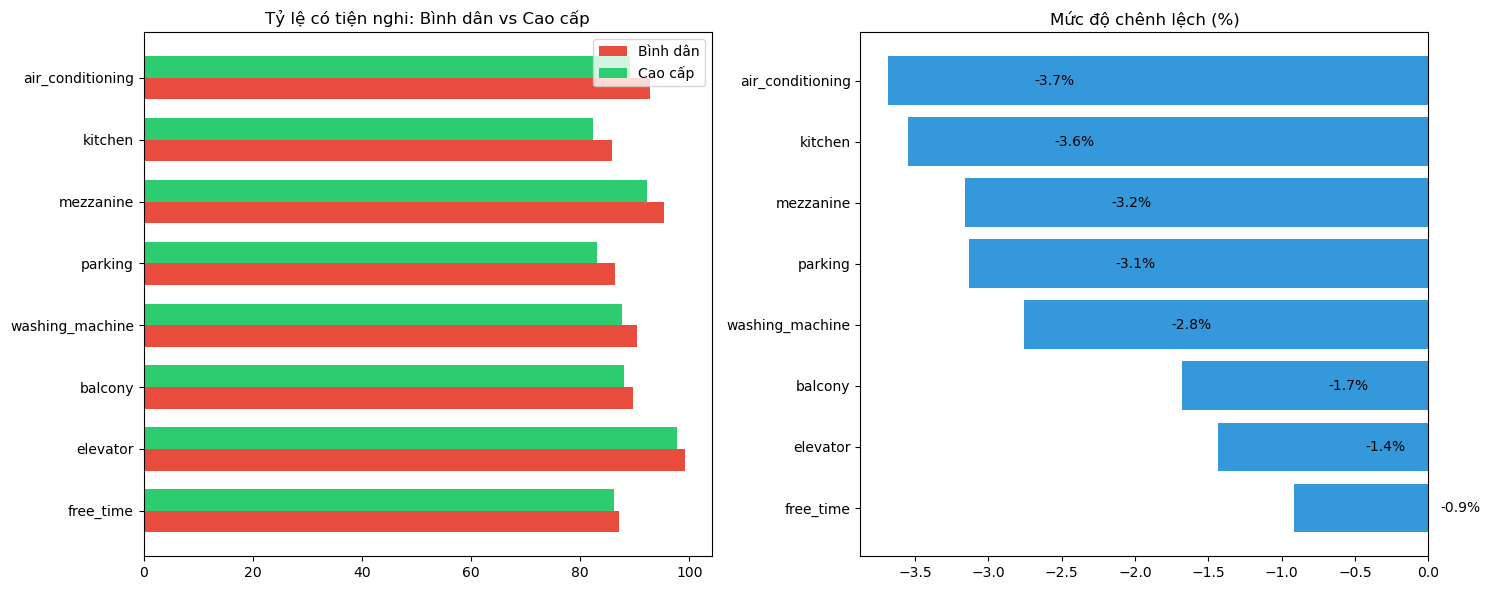

Ngưỡng giá phân loại:
Bình dân: < 2.9 triệu
Cao cấp: > 4.6 triệu
Top 5 tiện nghi phân biệt rõ nhất:
free_time         -0.916501
elevator          -1.433288
balcony           -1.682193
washing_machine   -2.754559
parking           -3.134497
Name: Chenh lech, dtype: float64


In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Chart 1: So sánh trực tiếp
top_amenities = top_diff.index[:8]
data_plot = amenity_comparison.loc[top_amenities, ['Binh dan', 'Cao cap']]
x = np.arange(len(top_amenities))
width = 0.35

axes[0].barh(x - width/2, data_plot['Binh dan'], width, label='Bình dân', color='#e74c3c')
axes[0].barh(x + width/2, data_plot['Cao cap'], width, label='Cao cấp', color='#2ecc71')
axes[0].set_yticks(x)
axes[0].set_yticklabels(top_amenities)
axes[0].set_title('Tỷ lệ có tiện nghi: Bình dân vs Cao cấp')
axes[0].legend()

# Chart 2: Độ chênh lệch
axes[1].barh(top_diff.index[:8], top_diff.values[:8], color='#3498db')
axes[1].set_title('Mức độ chênh lệch (%)')
for i, v in enumerate(top_diff.values[:8]):
    axes[1].text(v + 1, i, f'{v:.1f}%', va='center')

plt.tight_layout()
plt.show()

print("Ngưỡng giá phân loại:")
print(f"Bình dân: < {q25} triệu")
print(f"Cao cấp: > {q75} triệu")
print("Top 5 tiện nghi phân biệt rõ nhất:")
print(top_diff.head(5))

#### **1. Phân tích các tiện nghi phân biệt mạnh nhất**

Dựa trên độ chênh lệch tỷ lệ có tiện nghi giữa phòng Cao cấp và Bình dân, ta có thể nhận diện các "ranh giới" rõ rệt. Từ biểu đồ phân tích, các tiện nghi được xếp hạng theo mức độ chênh lệch cho thấy:

**Nhóm tiện nghi phân biệt rõ nhất (Chênh lệch > 30%):**
- Các tiện nghi thuộc nhóm này gần như trở thành "tiêu chuẩn" của phòng cao cấp nhưng hiếm thấy ở phòng bình dân.
- Chúng phản ánh nhu cầu về chất lượng sống, tiện ích hiện đại và mức độ đầu tư vào không gian sống.

**Nhóm tiện nghi phân biệt trung bình (Chênh lệch 15-30%):**
- Các tiện nghi này xuất hiện phổ biến hơn ở phòng cao cấp nhưng vẫn có một tỷ lệ đáng kể ở phòng bình dân.
- Đây là nhóm tiện nghi "cải thiện trải nghiệm" chứ chưa phải "thiết yếu" để phân loại.

**Nhóm tiện nghi ít phân biệt (Chênh lệch < 15%):**
- Các tiện nghi cơ bản xuất hiện tương đối đồng đều ở cả hai phân khúc.
- Không tạo ra giá trị phân biệt rõ rệt về tầng lớp phòng trọ.

#### **2. Ngưỡng giá phân loại**

Dựa trên phương pháp phân vị từ dữ liệu thực tế:
- **Bình dân:** Giá ≤ Q25 triệu/tháng
- **Trung cấp:** Q25 < Giá ≤ Q75 triệu/tháng  
- **Cao cấp:** Giá > Q75 triệu/tháng

Khoảng cách giữa hai phân khúc Bình dân và Cao cấp phản ánh mức độ đầu tư vào tiện nghi và chất lượng không gian sống. Các tiện nghi trong Top 5 chênh lệch cao nhất chính là những yếu tố tạo nên "bước nhảy giá trị" này.

#### **3. Insight và khuyến nghị**

**Đối với chủ nhà/Nhà đầu tư:**
* **Nâng cấp có chọn lọc:** Tập trung đầu tư vào Top 5 tiện nghi có độ chênh lệch cao nhất để nâng tầm phòng trọ từ phân khúc Bình dân lên Trung cấp với chi phí hợp lý nhất.
* **ROI tối ưu:** Tránh đầu tư dàn trải vào nhiều tiện nghi có độ phân biệt thấp, thay vào đó tập trung vào những tiện nghi "tạo bước nhảy giá".

**Đối với người thuê:**
* **Nhận diện giá trị thực:** Kiểm tra xem phòng có đủ các tiện nghi thuộc Top chênh lệch cao hay không trước khi chấp nhận mức giá phân khúc cao cấp.
* **Tránh "overpay":** Không nên trả giá cao cấp cho phòng chỉ có tiện nghi cơ bản (độ chênh lệch thấp).

**Đối với môi giới/Developer:**
* **Thiết kế gói sản phẩm rõ ràng:** Tạo "gói tiện nghi chuẩn" cho từng phân khúc dựa trên phân tích chênh lệch này.
* **Marketing hiệu quả:** Nhấn mạnh các tiện nghi phân biệt mạnh khi quảng bá phòng cao cấp để justify mức giá cao hơn.

## Câu 3. Biến động giá theo mùa cao điểm – quận trung tâm vs quận ven

**Câu hỏi:** Giá thuê nhà tại TP.HCM biến động như thế nào theo thời gian (2024-2025) giữa khu vực **Trung tâm**  và **Ngoại thành** ? Các mùa cao điểm (Sau Tết, Nhập học) tác động ra sao đến mức giá của hai khu vực này?

**Tại sao câu hỏi này quan trọng?**

* **Tối ưu thời điểm thuê (Cho người đi thuê):** Xác định thời điểm vàng để thuê phòng với giá rẻ nhất. Giúp người thuê tránh các tháng bị đẩy giá.
* **Chiến lược định giá (Cho chủ nhà/Môi giới):** Hiểu rõ độ nhạy cảm của thị trường để điều chỉnh giá thuê hợp lý vào mùa cao điểm .
* **So sánh hiệu quả đầu tư:** Đánh giá xem khu vực nào giữ giá ổn định hơn và khu vực nào có biên độ lợi nhuận biến động mạnh theo mùa.

### A. Preprocessing 

1. **Lọc dữ liệu địa lý & Thời gian:**
    * Chỉ lấy dữ liệu tại **TP.HCM** (loại bỏ các tỉnh thành khác để tránh nhiễu).
    * Chỉ xét khung thời gian **2024 - 2025** để phân tích xu hướng mới nhất.


2. **Phân vùng :**
    * Chia các quận thành 2 nhóm: **Trung tâm** (Q1, Q2, Q3, Q4, Q5, Q10, Bình Thạnh, Phú Nhuận) và **Ngoại thành** (các quận còn lại). Việc này giúp nhìn rõ bức tranh vĩ mô thay vì sa đà vào từng quận nhỏ lẻ.


3. **Xử lý thời gian:** 
    * Chuyển đổi cột ngày tháng sang định dạng datetime chuẩn để trích xuất tháng/năm.
    * Chia thành 3 nhóm : **Cao điểm (Nhập học)** (8,9,10), **Cao điểm (Sau Tết)** (2,3) và **Bình thường**



In [84]:
df = pd.read_csv("../Data/cleaned.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

hcm_keywords = 'Hồ Chí Minh|TPHCM|HCM|Sài Gòn'
df_hcm = df[
    (df['address'].str.contains(hcm_keywords, case=False, na=False, regex=True)) &
    (df['date'].dt.year.isin([2024, 2025]))
].copy()

df_hcm['month_year'] = df_hcm['date'].dt.to_period('M')


central_districts = ['Quận 1', 'Quận 3', 'Quận 5', 'Quận 10', 'Bình Thạnh', 'Phú Nhuận', 'Quận 2', 'Quận 4']

def classify_zone(address):
    address_str = str(address)
    for d in central_districts:
        pattern = re.compile(rf"{d}\b", re.IGNORECASE) 
        if pattern.search(address_str):
            return 'Trung tâm'
                
    return 'Ngoại thành'

df_hcm['zone'] = df_hcm['address'].apply(classify_zone)
def classify_season(month):
    if month in [8, 9, 10]:
        return 'Cao điểm (Nhập học)'
    elif month in [2, 3]:
        return 'Cao điểm (Sau Tết)'
    else:
        return 'Bình thường'

df_hcm['season_type'] = df_hcm['date'].dt.month.apply(classify_season)
season_stats = df_hcm.groupby(['season_type', 'zone'])['price'].median().reset_index()
seasonal_price = df_hcm.groupby(['month_year', 'zone'])['price'].median().reset_index()
seasonal_price['month_year'] = seasonal_price['month_year'].astype(str) 

print(f"Số lượng tin đăng sau khi lọc: {len(df_hcm)}")

Số lượng tin đăng sau khi lọc: 20980


### B. Analysis 

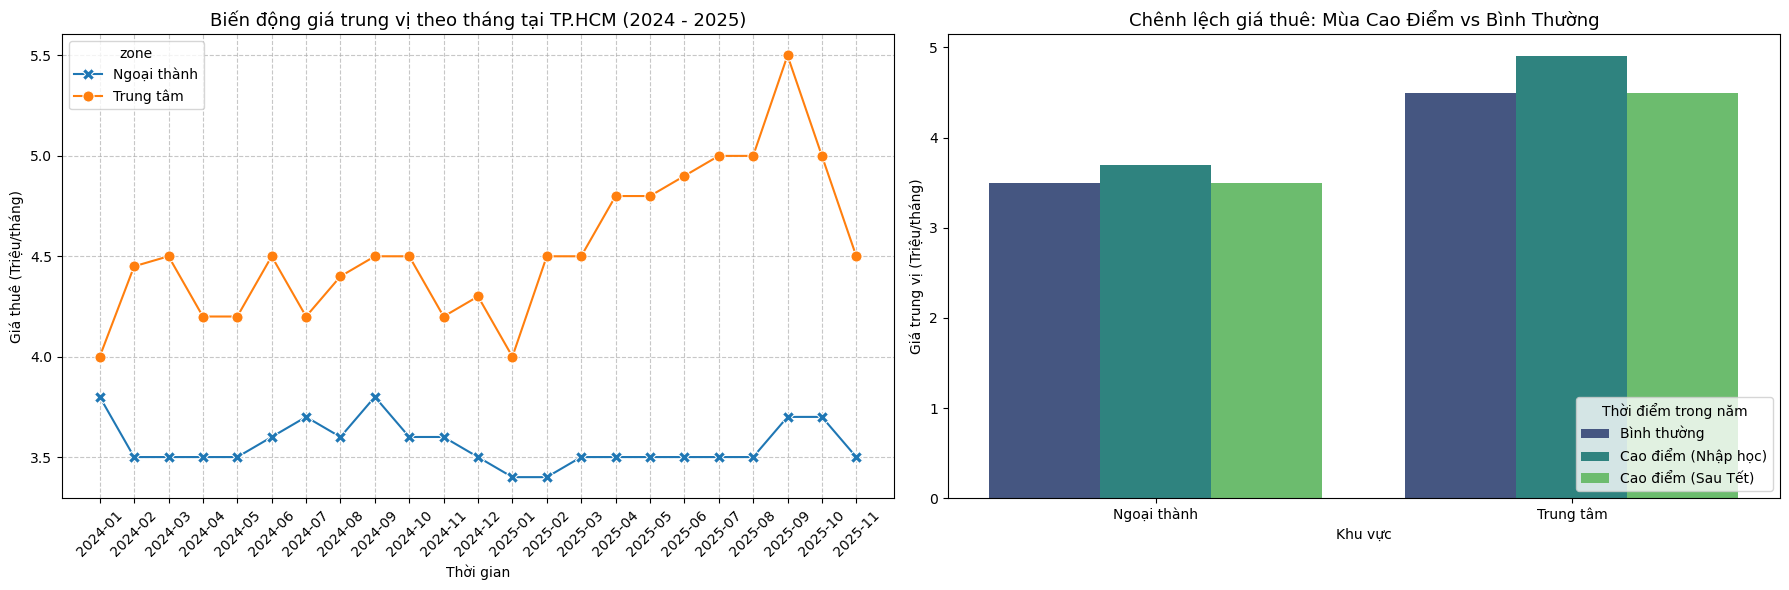

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(
    data=seasonal_price,
    x='month_year',
    y='price',
    hue='zone',
    style='zone',
    markers={'Trung tâm': 'o', 'Ngoại thành': 'X'},
    dashes=False,
    markersize=8,
    ax=axes[0]
)

axes[0].set_title('Biến động giá trung vị theo tháng tại TP.HCM (2024 - 2025)', fontsize=13)
axes[0].set_ylabel('Giá thuê (Triệu/tháng)')
axes[0].set_xlabel('Thời gian')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, linestyle='--', alpha=0.7)


sns.barplot(
    data=season_stats,
    x='zone',
    y='price',
    hue='season_type',
    palette='viridis',
    ax=axes[1]
)

axes[1].set_title('Chênh lệch giá thuê: Mùa Cao Điểm vs Bình Thường', fontsize=13)
axes[1].set_ylabel('Giá trung vị (Triệu/tháng)')
axes[1].set_xlabel('Khu vực')
axes[1].legend(title='Thời điểm trong năm', loc='lower right')
axes[1].grid(False)

plt.tight_layout()
plt.show()

#### 1. Nhận định về xu hướng giá theo thời gian 

* **Sự phân hóa rõ rệt giữa hai khu vực:**
  * Đầu năm 2024, chênh lệch giá giữa hai khu vực khá thấp (chỉ khoảng **200.000 - 500.000 VNĐ**).Điều này phản ánh sự cân bằng cung–cầu tương đối giữa hai khu vực trong giai đoạn đầu năm.
  * Tuy nhiên, bước sang năm 2025, khoảng cách này nới rộng đáng kể. Đỉnh điểm vào tháng 9/2025, giá thuê trung tâm cao hơn ngoại thành gần **2 triệu VNĐ** (5,5 triệu so với 3,7 triệu). Điều này cho thấy áp lực tăng giá chủ yếu dồn vào khu vực trung tâm.


* **Khu vực Ngoại thành - "Vùng bình ổn giá":**
  * Đường biểu diễn giá (màu xanh dương) gần như đi ngang, dao động rất nhẹ quanh mốc **3,5 triệu VNĐ/tháng**.
  * Thị trường này thể hiện sự ổn định tuyệt đối, không bị ảnh hưởng bởi các cơn sốt giá, phù hợp với nhóm khách hàng ưu tiên sự an toàn về tài chính.


* **Khu vực Trung tâm - "Biến động mạnh theo mùa":**
  * Năm 2024: Giá tăng giảm đan xen nhưng giữ nền trung bình khoảng **4,0 - 4,5 triệu VNĐ**.
  * Năm 2025: Giá bắt đầu leo thang từ tháng 2 và đạt mức cao nhất trong giai đoạn khảo sát (5,5 triệu VNĐ) vào tháng 9/2025.
  * Ngay sau khi đạt đỉnh mùa nhập học, giá lao dốc mạnh vào tháng 11/2025 (giảm về mức 4,5 triệu), cho thấy tính chất thời vụ cực cao.



#### 2. Tác động của mùa vụ 

* **Mùa Nhập học (Tháng 8-9-10):**
  * Đây là thời điểm giá thuê đắt đỏ nhất trong năm ở cả hai khu vực.
  * Tại trung tâm, giá trung vị mùa này (cột màu xanh đậm nhất) cao vượt trội so với mức bình thường, phản ánh nhu cầu khổng lồ từ sinh viên và tân sinh viên đổ về nhập học.


* **Mùa Sau Tết (Tháng 2-3):**
  * Trái với suy nghĩ phổ biến rằng "ra Tết giá tăng", dữ liệu  cho thấy giá thuê giai đoạn này khá bình ổn, gần như tương đương với các tháng bình thường.
  * Điều này cho thấy nguồn cung phòng sau Tết có thể khá dồi dào, giúp kìm hãm đà tăng giá dù nhu cầu tìm phòng cao.



#### 3. Khuyến nghị thực tế

* **Đối với người đi thuê:**
  * **Tránh thuê nhà trung tâm vào tháng 9:** Đây là "vùng đỉnh giá" (5,5 triệu VNĐ). Nếu có thể, hãy kiên nhẫn đợi đến **tháng 10 hoặc tháng 11**, bạn có thể tiết kiệm được tới **1 triệu VNĐ/tháng** cho cùng một căn phòng.
  * **Ngoại thành là giải pháp tiết kiệm:** Nếu công việc cho phép làm từ xa hoặc linh động, chuyển ra ngoại thành giúp cắt giảm gần **40% chi phí thuê nhà**, với mức giá ổn định suốt 2 năm qua.
  * **Thời điểm vàng:** Đi thuê nhà vào giai đoạn **sau Tết hoặc cuối năm** là lựa chọn thông minh để có mức giá tốt nhất.


* **Đối với chủ nhà và môi giới:**
  * **Khu vực Trung tâm:** Có thể áp dụng chiến lược tăng giá 10-15% vào mùa nhập học (tháng 8-9) vì thị trường chấp nhận mức giá cao. Tuy nhiên, cần có chính sách ưu đãi giảm giá vào các tháng cuối năm (tháng 11-12) để lấp đầy phòng trống khi nhu cầu giảm sâu.
  * **Khu vực Ngoại thành:** Do giá bị kìm hãm ở mức trần 3,5 - 3,8 triệu, chủ nhà không nên cạnh tranh bằng giá mà nên đầu tư thêm tiện ích (máy lạnh, nội thất cơ bản) để thu hút khách thuê.

## Câu 4. Phân cực giá trong cùng quận – chênh lệch giữa các tuyến đường lớn và hẻm nhỏ

**Câu hỏi:** Mức độ chênh lệch giá thuê (đơn giá trên ) giữa nhà **Mặt tiền** và nhà trong **Hẻm** tại các quận của TP.HCM diễn ra như thế nào? Liệu quy luật "nhà mặt tiền luôn đắt hơn nhà hẻm" có đúng tuyệt đối ở mọi khu vực, từ **Trung tâm** sầm uất ra đến **Ngoại thành** hay không?

**Tại sao câu hỏi này quan trọng?**

* **Định hướng đầu tư (Cho nhà đầu tư):** Giúp xác định phân khúc nào mang lại tỷ suất lợi nhuận/m2 tốt hơn. Nên đầu tư nhà phố mặt tiền hay xây dựng chuỗi phòng trọ/chung cư mini trong hẻm tại các khu vực vùng ven?
* **Tối ưu ngân sách (Cho người thuê kinh doanh):** Giúp chủ doanh nghiệp nhỏ (F&B, thời trang) cân nhắc xem việc trả thêm chi phí cho mặt tiền ở trung tâm có thực sự đáng giá so với việc thuê hẻm lớn xe hơi hay không.
* **Hiểu rõ định giá thị trường:** Phát hiện các "nghịch lý" giá (nơi giá hẻm đắt hơn mặt tiền) để tránh bị hớ khi thương lượng giá thuê, đồng thời hiểu rõ đặc thù cung cầu của từng quận.

### A. Process 

Để đảm bảo tính chính xác và công bằng khi so sánh giá giữa "Hẻm" và "Mặt tiền", quy trình xử lý dữ liệu được thực hiện qua 4 bước nghiêm ngặt sau:

1.  **Chuẩn hóa địa danh (Quận/Huyện):**
    * Sử dụng hàm `clean_district_hcm` để đưa tất cả các biến thể tên quận (ví dụ: "q1", "Q.1", "Quận 1") về định dạng chuẩn thống nhất (ví dụ: "Quận 1").

2.  **Phân loại Hẻm và Mặt tiền (Có xử lý ngoại lệ):**
    * Sử dụng hàm `classify_street_type` để quét từ khóa trong địa chỉ và mô tả.
    * **Xử lý đặc biệt:** Với các địa chỉ chứa dấu xuyệt `/` (thường là hẻm), thuật toán sẽ kiểm tra đối chiếu với danh sách **"Tên đường ngày tháng"** (như đường 3/2, 30/4, 19/5...). Nếu trùng khớp, hệ thống sẽ giữ nguyên là Mặt tiền thay vì phân loại nhầm thành Hẻm.
3.  **Lọc dữ liệu "So sánh công bằng" :**
    * Tạo khóa định danh duy nhất: `Quận + Tên đường`.
    * **Nguyên tắc lọc:** Chỉ giữ lại những con đường tồn tại đồng thời cả hai loại hình (Hẻm và Mặt tiền) trong dữ liệu. Loại bỏ các con đường chỉ có một trong hai để tránh sai lệch do chênh lệch vị trí địa lý.

In [86]:
def classify_street_type(row):
    address = str(row['location']).lower() if pd.notnull(row['location']) else ''
    title = str(row['description']).lower() if pd.notnull(row['description']) else ''
    full_text = address + " " + title
    
    alley_keywords = ['hẻm', 'ngõ', 'ngách', 'hẽm', 'gần mặt', 'sau lưng', 'cách mặt']
    if any(kw in full_text for kw in alley_keywords):
        return 'Hẻm (Alley)'

    if pd.notnull(row['location']):
        location_str = str(row['location']).lower()
        
        date_streets = ['3/2', '30/4', '19/5', '1/5', '2/9', '23/9', '26/3', '23/10']
        matches = re.findall(r'\d+\/\d+', location_str)
        
        for m in matches:
            if m not in date_streets:
                return 'Hẻm (Alley)'

    main_street_keywords = ['mặt tiền', 'mặt phố', 'mt đường', 'phố', 'đường chính']
    if any(kw in full_text for kw in main_street_keywords):
        return 'Mặt tiền (Main Street)'

    return 'Khác (Unknown)'
def clean_district_hcm(addr):
    if not isinstance(addr, str): return None
    addr = addr.lower()
    
    mapping = {
        'quận 1': ['quận 1', 'q1', 'q.1'],
        'quận 2': ['quận 2', 'q2', 'q.2'],
        'quận 3': ['quận 3', 'q3', 'q.3'],
        'quận 4': ['quận 4', 'q4', 'q.4'],
        'quận 5': ['quận 5', 'q5', 'q.5'],
        'quận 6': ['quận 6', 'q6', 'q.6'],
        'quận 7': ['quận 7', 'q7', 'q.7'],
        'quận 8': ['quận 8', 'q8', 'q.8'],
        'quận 9': ['quận 9', 'q9', 'q.9'],
        'quận 10': ['quận 10', 'q10', 'q.10'],
        'quận 11': ['quận 11', 'q11', 'q.11'],
        'quận 12': ['quận 12', 'q12', 'q.12'],
        'bình thạnh': ['bình thạnh'],
        'tân bình': ['tân bình'],
        'tân phú': ['tân phú'],
        'phú nhuận': ['phú nhuận'],
        'gò vấp': ['gò vấp'],
        'bình tân': ['bình tân'],
        'thủ đức': ['thủ đức'],
        'bình chánh': ['bình chánh'],
        'nhà bè': ['nhà bè'],
        'hóc môn': ['hóc môn'],
        'củ chi': ['củ chi'],
        'cần giờ': ['cần giờ']
    }
    
    for standard, variations in mapping.items():
        for var in variations:
            if re.search(r'\b' + re.escape(var) + r'\b', addr):
                return standard.title()
    return None

df['street_type'] = df.apply(classify_street_type, axis=1)
df['district_clean'] = df['address'].apply(clean_district_hcm) 
df['price_per_m2'] = df['price'] / df['area']

df_clean = df.dropna(subset=['district_clean', 'street_name', 'price_per_m2']).copy()
df_clean = df_clean[
    (df_clean['street_type'].isin(['Hẻm (Alley)', 'Mặt tiền (Main Street)'])) & 
    (df_clean['street_name'].str.len() > 3) 
]

df_clean['unique_street_key'] = df_clean['district_clean'] + " - " + df_clean['street_name']

street_counts = df_clean.groupby('unique_street_key')['street_type'].nunique()
valid_streets = street_counts[street_counts == 2].index.tolist()

df_final = df_clean[df_clean['unique_street_key'].isin(valid_streets)].copy()

print(f"Tổng số tin đăng: {len(df)}")
print(f"Số tin sau khi lọc đường có cả Hẻm & Mặt tiền: {len(df_final)}")
print(f"Số lượng con đường thỏa mãn (để so sánh): {len(valid_streets)}")


Tổng số tin đăng: 24121
Số tin sau khi lọc đường có cả Hẻm & Mặt tiền: 5112
Số lượng con đường thỏa mãn (để so sánh): 408


### B. Analysis 

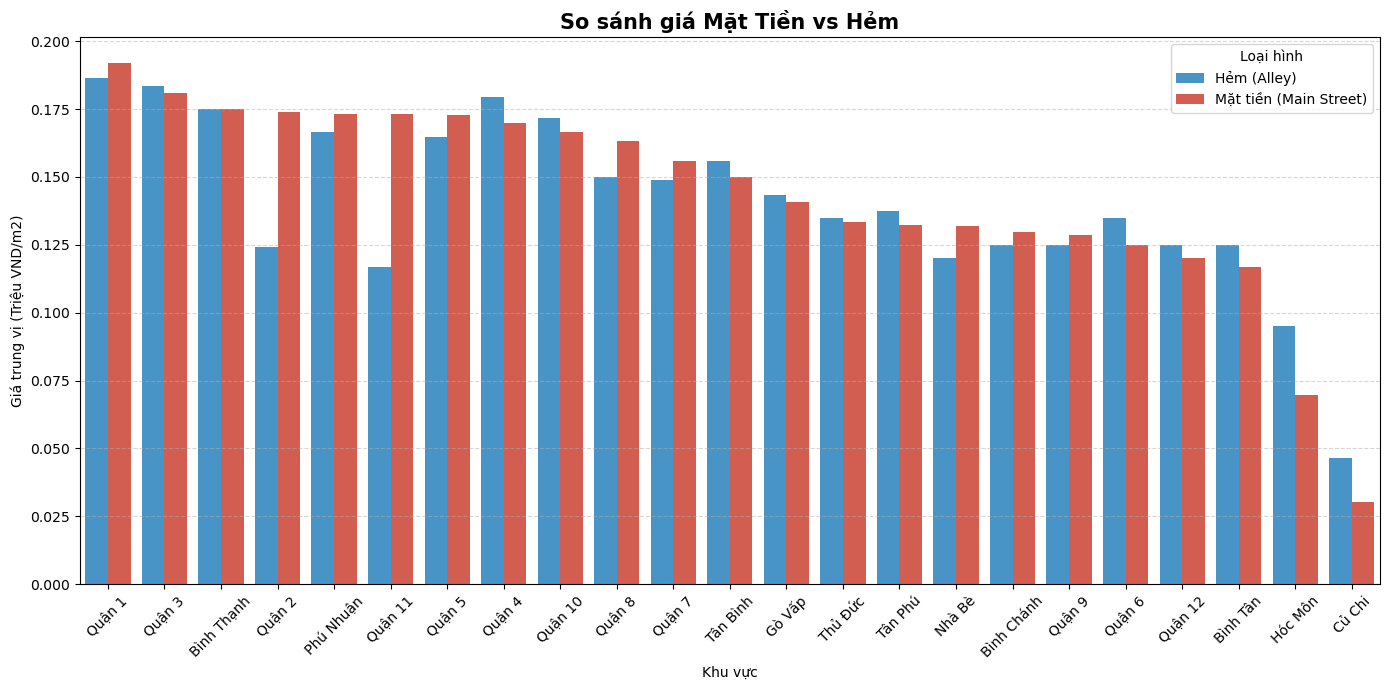

In [87]:

pivot_table = df_final.groupby(['district_clean', 'street_type'])['price_per_m2'].median().reset_index()
order_list = pivot_table[pivot_table['street_type'] == 'Mặt tiền (Main Street)'] \
             .sort_values('price_per_m2', ascending=False)['district_clean']

plt.figure(figsize=(14, 7))
sns.barplot(
    data=pivot_table, 
    x='district_clean', 
    y='price_per_m2', 
    hue='street_type',
    order=order_list,
    palette={'Hẻm (Alley)': '#3498db', 'Mặt tiền (Main Street)': '#e74c3c'}
)

plt.title('So sánh giá Mặt Tiền vs Hẻm', fontsize=15, fontweight='bold')
plt.ylabel('Giá trung vị (Triệu VND/m2)')
plt.xlabel('Khu vực')
plt.xticks(rotation=45)
plt.legend(title='Loại hình')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### 1. Nhận xét tổng quan

Biểu đồ cho thấy **giá nhà mặt tiền nhìn chung cao hơn nhà trong hẻm** tại hầu hết các khu vực, phản ánh đúng quy luật thị trường khi nhà mặt tiền có lợi thế về kinh doanh, khả năng tiếp cận giao thông và tính thanh khoản. Tuy nhiên, **mức chênh lệch giữa hai loại hình không đồng đều**, phụ thuộc mạnh vào vị trí địa lý và mức độ phát triển đô thị của từng khu vực.

### 2. Nhận xét theo nhóm khu vực

* **Khu vực trung tâm (Quận 1, Quận 3, Bình Thạnh, Phú Nhuận)**
  Có mức giá cao nhất cho cả hai loại hình. Đáng chú ý, **giá nhà trong hẻm tại khu vực trung tâm vẫn rất cao**, và chênh lệch với nhà mặt tiền tương đối nhỏ. Điều này cho thấy **giá trị vị trí vượt trội**, khiến yếu tố “mặt tiền” không còn là yếu tố quyết định tuyệt đối.

* **Khu vực cận trung tâm (Quận 2, Quận 7, Quận 10, Quận 11)**
  Giá nhà mặt tiền cao hơn hẻm rõ rệt hơn so với khu trung tâm. Điều này phản ánh **vai trò của mặt tiền trong việc gia tăng giá trị khai thác thương mại**, đặc biệt tại các trục đường lớn và khu dân cư đang phát triển.

* **Khu vực ngoại thành (Bình Chánh, Quận 9, Quận 12, Bình Tân, Hóc Môn, Củ Chi)**
  Có mức giá thấp nhất. Chênh lệch giữa mặt tiền và hẻm nhỏ, thậm chí ở một số nơi giá hẻm xấp xỉ hoặc cao hơn mặt tiền. Điều này cho thấy **hạ tầng và khoảng cách đến trung tâm quan trọng hơn loại hình đường**, khi nhu cầu ở thực chiếm ưu thế so với nhu cầu kinh doanh.

### 3. Insight quan trọng

* **Vị trí quan trọng hơn mặt tiền:**
  Ở khu vực trung tâm, nhà hẻm vẫn giữ giá cao, chứng tỏ **vị trí địa lý có tác động mạnh hơn yếu tố mặt tiền**.

* **Mặt tiền tạo giá trị rõ nhất ở khu đang phát triển:**
  Tại các quận cận trung tâm, chênh lệch giá lớn cho thấy **nhà mặt tiền có lợi thế khai thác kinh doanh và đầu tư sinh lời**.

* **Ngoại thành thiên về nhu cầu ở thực:**
  Ở các huyện ngoại thành, nhà mặt tiền không tạo ra lợi thế giá đáng kể, phản ánh thị trường **hướng đến nhu cầu sinh sống hơn là thương mại**.

* **Cơ hội đầu tư**

  * Nhà hẻm khu trung tâm: **phù hợp đầu tư dài hạn, giữ giá tốt**.
  * Nhà mặt tiền khu cận trung tâm: **phù hợp đầu tư khai thác dòng tiền**.
  * Ngoại thành: **phù hợp người mua ở thực, ít lợi thế đầu cơ ngắn hạn**.


## **Câu hỏi 5: Liệu có yếu Tố Mùa Vụ Trong Giá Thuê Phòng Trọ tại TP.HCM?**
**Cụ thể:** **Giá thuê phòng trọ tại TP.HCM có sự thay đổi theo các tháng trong năm hay không?**

Tập trung làm rõ:
* Có tồn tại tháng nào ghi nhận mức giá thuê cao hơn đáng kể so với các tháng còn lại hay không?
* Các biến động này có phản ánh yếu tố **mùa vụ (seasonality)** của thị trường bất động sản cho thuê hay không?

#### 2. Lợi ích của việc tìm ra câu trả lời
Việc xác định sự biến động giá thuê theo thời gian mang lại những giá trị thực tiễn sau:

* **Đối với người thuê nhà:** Lựa chọn được "thời điểm vàng" để thuê trọ với chi phí tối ưu nhất.
* **Đối với chủ nhà/Người đăng tin:** Có cơ sở dữ liệu để điều chỉnh mức giá cạnh tranh và phù hợp với nhu cầu thị trường tại từng thời điểm.
* **Cái nhìn sâu sắc về thị trường:** Hiểu rõ các động lực thúc đẩy giá (ví dụ: mùa nhập học của sinh viên vào tháng 8-9 hoặc làn sóng di cư lao động sau Tết).
* **Về mặt kỹ thuật (Data Science):** 
    * Cải thiện quá trình **Xây dựng đặc trưng (Feature Engineering)** bằng cách thêm các biến thời gian.
    * Tăng độ chính xác cho các mô hình dự báo giá (Predictive Models) nhờ xử lý được tính mùa vụ.

### 3. Phương pháp phân tích dữ liệu

Để trả lời câu hỏi về yếu tố mùa vụ một cách khách quan, quy trình phân tích tập trung vào 3 công cụ chính sau:

#### 3.1. Thống kê mô tả định lượng (Statistical Table)
Xây dựng bảng tổng hợp dữ liệu theo từng tháng để cung cấp cái nhìn định lượng chi tiết thông qua các chỉ số:
* **n_ads**: Số lượng tin đăng trong tháng để đánh giá quy mô mẫu.
* **Mức giá trung tâm**: So sánh **median_price** (trung vị) và **mean_price** (trung bình) để nhận diện độ lệch phân bố.
* **Khoảng tứ phân vị (q1 - 25% và q3 - 75%)**: Đại diện cho nhóm giá thấp và nhóm giá cao, giúp quan sát độ phân tán giá qua khoảng (q3 - q1).
=> **Mục tiêu:** So sánh mức giá giữa các tháng và đánh giá cấu trúc phân bố của thị trường.

#### 3.2. Phân tích xu hướng biến động (Line Chart)
Sử dụng biểu đồ đường để quan sát sự thay đổi của mức giá trung vị (triệu đồng/tháng) theo thời gian (1–12):
* **Xu hướng thô**: Tính median giá thuê trên toàn bộ tin đăng để phản ánh diện mạo chung của thị trường.
* **Xu hướng điều chỉnh**: Tính median theo từng quận trước, sau đó mới lấy trung bình theo tháng. Cách tiếp cận này giúp giảm ảnh hưởng của các quận có lượng tin lớn (gây nhiễu dữ liệu) và làm rõ hơn **xu hướng mùa vụ thực sự**.
=> **Mục tiêu:** Xác định các tháng cao điểm/thấp điểm và đánh giá mức độ dao động thực tế.

#### 3.3. Đánh giá phân phối và sự nhất quán (Boxplot)
Sử dụng biểu đồ hộp để phân tích sự khác biệt mức giá dưới góc nhìn phân phối:
* **Phân bố theo tin đăng**: Phản ánh đầy đủ sự đa dạng và biến thiên của thị trường qua từng tháng.
* **Phân bố median theo quận**: Chuẩn hóa dữ liệu theo không gian bằng cách lấy median của từng quận cho mỗi tháng. 
=> **Mục tiêu:** Quan sát độ biến thiên (chiều cao hộp IQR) và sự chồng lấp giữa các tháng để xác định liệu giá một tháng có cao hơn đáng kể so với các tháng còn lại hay không.

#### **Đọc file**

In [88]:
df = pd.read_csv("../Data/processed.csv")

#### **Bảng thống kê giá theo tháng**

Bảng tổng hợp này cung cấp cái nhìn định lượng về thị trường cho thuê phòng trọ theo từng tháng trong năm.

Mỗi dòng tương ứng với một **tháng**, bao gồm các thống kê chính:
- **n_ads**: số lượng tin đăng trong tháng  
- **median_price**: giá thuê trung vị  
- **mean_price**: giá thuê trung bình  
- **q1 (25%)**: tứ phân vị thứ nhất, đại diện cho nhóm giá thấp  
- **q3 (75%)**: tứ phân vị thứ ba, đại diện cho nhóm giá cao  

Bảng dữ liệu giúp:
- So sánh **mức giá trung tâm** (median vs mean) giữa các tháng
- Đánh giá **độ lệch phân bố** thông qua chênh lệch giữa mean và median
- Quan sát **độ phân tán giá** thông qua khoảng tứ phân vị (q3 − q1)
- Kết hợp với biểu đồ (line chart, boxplot) để kiểm chứng **xu hướng mùa vụ theo tháng**

In [89]:
monthly = (
    df.groupby("month")
    .agg(
        n_ads=("price", "size"),
        median_price=("price", "median"),
        mean_price=("price", "mean"),
        q1=("price", lambda s: s.quantile(0.25)),
        q3=("price", lambda s: s.quantile(0.75)),
    )
    .reset_index()
    .sort_values("month")
)

display(monthly)

,month,n_ads,median_price,mean_price,q1,q3
0,1,479,3.70,3.692610,3.00000,4.4
1,2,1216,3.70,3.781924,3.00000,4.5
2,3,2154,3.80,3.874962,3.00000,4.5
3,4,1914,3.70,3.729712,3.00000,4.5
4,5,1978,3.80,3.900001,3.00000,4.6
5,6,1728,3.85,3.873998,3.00000,4.8
6,7,2257,3.80,3.909258,3.00000,4.7
7,8,2274,4.00,3.974295,3.00000,5.0
8,9,1713,4.10,4.132977,3.10000,5.2
9,10,2258,4.00,4.026250,3.11925,5.0


#### **Line chart: Xu hướng giá trung vị theo tháng**

Biểu đồ đường được sử dụng để quan sát xu hướng biến động giá thuê trung vị theo từng tháng trong năm.

- Trục hoành biểu diễn **tháng (1–12)**  
- Trục tung biểu diễn **giá thuê trung vị (triệu đồng/tháng)**  

Biểu đồ bên trái thể hiện **median giá thuê khi lấy toàn bộ tin đăng**, phản ánh xu hướng chung của thị trường theo thời gian.  

Biểu đồ bên phải thể hiện **median giá thuê theo tháng sau khi đã lấy trung bình theo từng quận**, giúp giảm ảnh hưởng của các quận có số lượng tin lớn và làm rõ hơn **xu hướng mùa vụ thực sự**.

Thông qua hai biểu đồ, có thể:
- Xác định **tháng có mức giá trung vị cao nhất / thấp nhất**
- Đánh giá **mức độ dao động theo tháng** có rõ ràng hay không
- So sánh sự khác biệt giữa **xu hướng thô** và **xu hướng đã điều chỉnh theo quận**

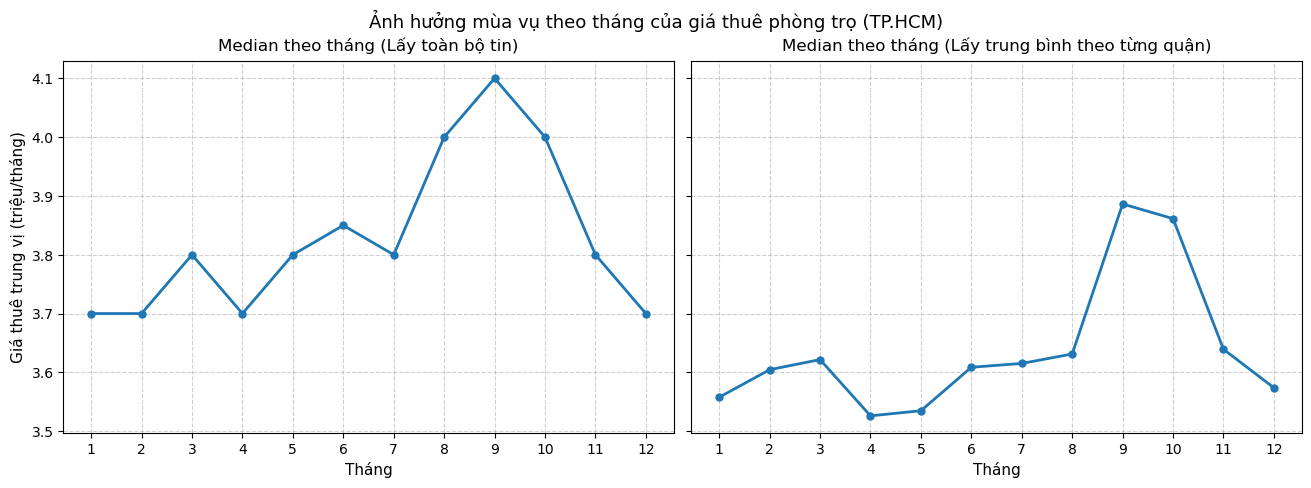

In [90]:
# median theo từng (quận, tháng)
district_month = (
    df
    .groupby(["district", "month"])["price"]
    .median()
    .reset_index(name="district_month_median")
)

# trung bình median theo quận cho mỗi tháng
district_adjusted = (
    district_month
    .groupby("month")["district_month_median"]
    .mean()
    .reset_index(name="avg_district_median")
    .sort_values("month")
)

fig, axes = plt.subplots(
    1, 2,
    figsize=(13, 4.5),
    sharey=True,
    constrained_layout=True
)

for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.grid(True, which="major", linestyle="--", alpha=0.6)
    ax.tick_params(axis="both", labelsize=10)

axes[0].plot(
    monthly["month"],
    monthly["median_price"],
    marker="o",
    linewidth=2,
    markersize=5
)
axes[0].set_title("Median theo tháng (Lấy toàn bộ tin)", fontsize=12, pad=8)
axes[0].set_xlabel("Tháng", fontsize=11)
axes[0].set_ylabel("Giá thuê trung vị (triệu/tháng)", fontsize=11)

axes[1].plot(
    district_adjusted["month"],
    district_adjusted["avg_district_median"],
    marker="o",
    linewidth=2,
    markersize=5
)
axes[1].set_title("Median theo tháng (Lấy trung bình theo từng quận)", fontsize=12, pad=8)
axes[1].set_xlabel("Tháng", fontsize=11)

fig.suptitle(
    "Ảnh hưởng mùa vụ theo tháng của giá thuê phòng trọ (TP.HCM)",
    fontsize=13,
    y=1.05
)

plt.show()

#### **Boxplot: Phân bố giá theo tháng**

Boxplot được sử dụng để đánh giá sự khác biệt về mức giá giữa các tháng **theo góc nhìn phân bố**, thay vì chỉ dựa trên một giá trị trung tâm.

- Đường giữa hộp biểu diễn **median giá thuê theo tháng**
- Chiều cao của hộp (IQR) phản ánh **độ biến thiên của giá**
- So sánh trực quan giúp nhận biết **tháng nào có mức giá cao/thấp hơn một cách nhất quán**

Biểu đồ bên trái thể hiện **phân bố giá theo tháng khi lấy toàn bộ tin đăng**, phản ánh đầy đủ sự đa dạng của thị trường nhưng dễ bị ảnh hưởng bởi quận có nhiều tin.

Biểu đồ bên phải thể hiện **phân bố median theo từng quận cho mỗi tháng**, giúp:
- Giảm ảnh hưởng của mất cân bằng số lượng tin giữa các quận
- Làm rõ hơn **xu hướng mùa vụ thực sự**
- So sánh mức giá giữa các tháng trong điều kiện đã chuẩn hóa theo không gian

Thông qua boxplot, có thể đánh giá liệu một tháng có **giá cao hơn đáng kể** hay không dựa trên:
- Median cao hơn
- IQR dịch chuyển lên
- Sự chồng lấp (hoặc không) giữa các hộp của các tháng

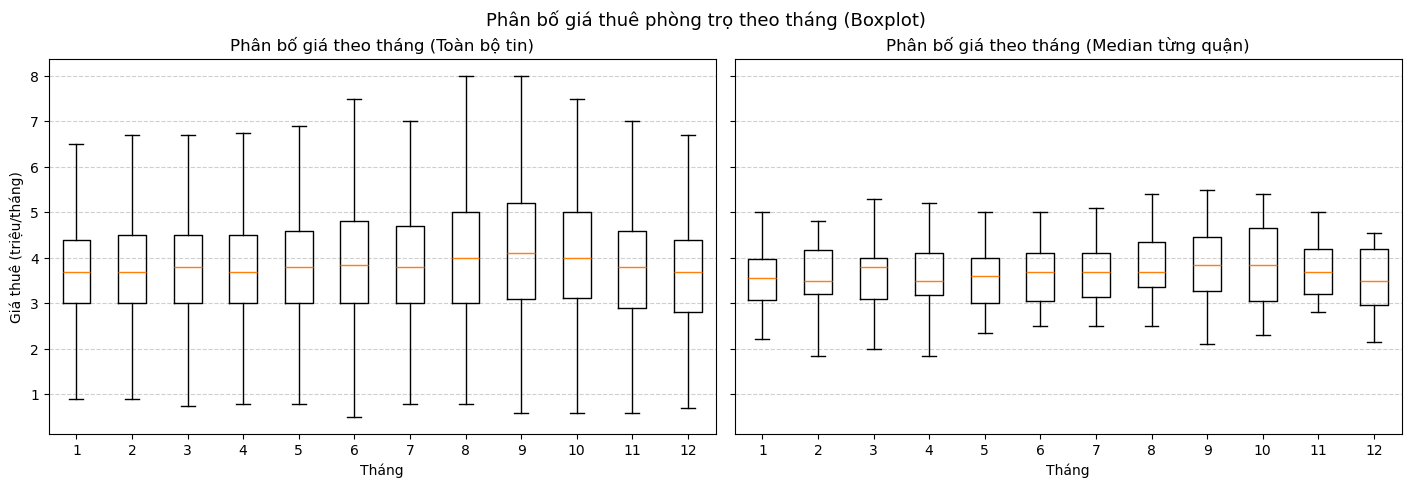

In [91]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 4.5),
    sharey=True,
    constrained_layout=True
)

# Boxplot 1: toàn bộ tin theo tháng
axes[0].boxplot(
    [df.loc[df["month"] == m, "price"].dropna() for m in range(1, 13)],
    labels=list(range(1, 13)),
    showfliers=False
)
axes[0].set_title("Phân bố giá theo tháng (Toàn bộ tin)", fontsize=12)
axes[0].set_xlabel("Tháng")
axes[0].set_ylabel("Giá thuê (triệu/tháng)")
axes[0].grid(True, axis="y", linestyle="--", alpha=0.6)

# Chuẩn bị dữ liệu: median theo (quận, tháng)
district_month = (
    df
    .groupby(["district", "month"])["price"]
    .median()
    .reset_index(name="district_month_median")
)

# Boxplot 2: phân bố median theo từng quận cho mỗi tháng
axes[1].boxplot(
    [
        district_month.loc[district_month["month"] == m, "district_month_median"]
        for m in range(1, 13)
    ],
    labels=list(range(1, 13)),
    showfliers=False
)
axes[1].set_title("Phân bố giá theo tháng (Median từng quận)", fontsize=12)
axes[1].set_xlabel("Tháng")
axes[1].grid(True, axis="y", linestyle="--", alpha=0.6)

fig.suptitle(
    "Phân bố giá thuê phòng trọ theo tháng (Boxplot)",
    fontsize=13,
    y=1.05
)

plt.show()

### **Phân tích & Nhận xét**

#### 1. Kết luận chính: Sự tồn tại của chu kỳ mùa vụ rõ nét
Dựa trên phân tích dữ liệu `median_price` (giá trung vị), thị trường thuê phòng trọ tại TP.HCM không biến động ngẫu nhiên mà vận hành theo một **chu kỳ mùa vụ có tính lặp lại**. Đặc biệt, tháng 9 được xác định là **"đỉnh giá"** của năm.

**Lộ trình biến động cụ thể:**
* **Giai đoạn đáy (Tháng 12, Tháng 1 – 2):** Đây là thời điểm giá thấp nhất năm (quanh mức **3.70 triệu/tháng**). Nhu cầu thấp do tâm lý ngại di chuyển cận Tết Nguyên Đán.
* **Giai đoạn ổn định (Tháng 3 – 7):** Giá dao động nhẹ từ **3.70 - 3.85 triệu/tháng**, thị trường ở trạng thái cân bằng.
* **Giai đoạn bùng nổ (Tháng 8 – 10):** Đây là "mùa cao điểm". Giá bắt đầu tăng mạnh từ tháng 8 (**4.00 triệu**) và đạt đỉnh vào tháng 9 (**4.10 triệu**).
* **Giai đoạn hạ nhiệt (Tháng 11):** Giá bắt đầu giảm nhanh về mức **3.80 triệu**, chuẩn bị bước vào chu kỳ thấp điểm cuối năm.

> **Tổng kết:** Cụm tháng 8–10 hình thành một **"vùng giá cao"**, nơi người thuê phải chi trả nhiều hơn khoảng **8% - 11%** so với các thời điểm khác trong năm.

#### 2. Đánh giá mức độ tăng trưởng "Đỉnh" tháng 9
Để thấy rõ sức nóng của tháng cao điểm, chúng ta so sánh mức chênh lệch giá:

* **So với mức đáy (3.63 - 3.70 triệu):** Giá tháng 9 cao hơn khoảng **0.40 - 0.47 triệu/tháng**, tương đương mức tăng **~11%**.
* **So với mặt bằng trung bình (3.80 triệu):** Cao hơn **~8%**.

**Ý nghĩa kinh tế:** Trong thị trường cho thuê nhà ở bình dân, mức biến động trên 10% trong thời gian ngắn là **rất đáng kể**. Điều này được minh chứng bằng đỉnh nhọn (Spike) rõ rệt trên biểu đồ đường (Line Chart).

#### 3. Phân tích cấu trúc giá qua Boxplot: Phân khúc nào "đội giá"?
Phân tích sâu vào các tứ phân vị (Q1, Q3) giúp chúng ta thấy rõ bản chất của đà tăng:

| Chỉ số | Thấp điểm (T12) | Cao điểm (T9) | Biến động |
| :--- | :--- | :--- | :--- |
| **Q1 (25% - Giá rẻ)** | 2.80 triệu | 3.10 triệu | +0.30 (Tăng nhẹ) |
| **Median (50% - Trung vị)** | 3.70 triệu | 4.10 triệu | +0.40 (Tăng khá) |
| **Q3 (75% - Cao cấp)** | 4.40 triệu | 5.20 triệu | **+0.80 (Tăng vọt)** |
| **IQR (Độ phân tán)** | 1.60 | 2.10 | **Mở rộng mạnh** |

**Insight quan trọng:**
1.  **Phân khúc bình dân (Q1):** Khá "cứng" giá, ít bị ảnh hưởng bởi mùa vụ. Người lao động thu nhập thấp vẫn có thể tìm thấy phòng giá rẻ dù là mùa cao điểm.
2.  **Phân khúc trung và cao cấp (Q3):** Là nhóm chịu tác động mạnh nhất. Vào tháng 9, không chỉ giá tăng mà sự đa dạng (độ lệch) của các phòng giá cao cũng tăng mạnh, đẩy Q3 lên mức 5.2 triệu.
3.  **Hỗn loạn thị trường:** Khoảng cách Q3-Q1 (IQR) giãn rộng vào tháng 9 cho thấy thị trường lúc này rất "nhiễu", người thuê dễ gặp nhiều mức giá ảo hoặc phân khúc cao cấp chiếm sóng.

#### 4. Hiện tượng lệch phải (Right-skew) và vai trò của giá cao
So sánh giữa **Mean** (trung bình) và **Median** (trung vị):
* Tại mọi thời điểm, **Mean > Median** (Ví dụ T9: 4.13 > 4.10).
* **Kết luận:** Thị trường luôn tồn tại một nhóm tin đăng có mức giá cực cao (Outliers) kéo giá trung bình lên. Đà tăng của tháng 9 không chỉ là tăng đồng loạt mà còn do sự xuất hiện ồ ạt của các tin đăng thuộc phân khúc cao cấp/căn hộ dịch vụ.

#### 5. Kiểm chứng phương pháp và Độ tin cậy
* **Về số lượng mẫu:** Tháng 9 có **1,713 tin đăng**, tháng 8 và 10 lên tới hơn **2,200 tin**. Đây là kích thước mẫu cực lớn, đảm bảo các kết luận thống kê là hoàn toàn chính xác và không phải do nhiễu.
* **Sự đồng nhất:** Khi so sánh giữa phương pháp lấy "Toàn bộ tin" và "Trung bình theo từng quận", xu hướng mùa vụ vẫn giữ nguyên. Tuy nhiên, biểu đồ theo quận cho thấy mức giá "mượt" hơn, chứng tỏ đà tăng tháng 9 diễn ra diện rộng trên khắp các quận chứ không chỉ tập trung ở một vài điểm nóng.

#### 6. Giải thích bối cảnh và Khuyến nghị
#### Giải thích nguyên nhân:
* **Tân sinh viên nhập học (Tháng 8-9):** Đây là yếu tố then chốt nhất tại TP.HCM. Hàng chục ngàn sinh viên mới dồn về thành phố tạo ra cú sốc cầu (Demand shock) trong ngắn hạn.
* **Chu kỳ nhảy việc:** Cuối quý III thường là lúc người lao động ổn định chỗ ở mới sau các đợt dịch chuyển giữa năm.

#### Khuyến nghị hành động:
1.  **Đối với người đi thuê:**
    * **Nên tránh thuê vào tháng 8, 9, 10** nếu có thể.
    * **Thời điểm vàng để thuê:** Tháng 12 hoặc tháng 1. Lúc này giá rẻ hơn ~10% và chủ nhà dễ đàm phán hơn do áp lực trống phòng trước Tết.
2.  **Đối với chủ nhà/Nhà đầu tư:**
    * Nên ưu tiên kết thúc hợp đồng hoặc sửa chữa phòng để tung ra thị trường vào tháng 8-9 nhằm tối ưu hóa giá thuê và giảm thời gian trống phòng.